In [1]:
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os

#import h5py
##import torchvision
#from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

#from torchvision import transforms
#from torch.utils import data
#from sklearn.model_selection import KFold



In [3]:
import csv

with open('flux-2.8-3.csv') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    X = list(reader)

with open('zpipe-2.8-3.csv') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    Y = list(reader)

#with open('zVI-2.8-3.csv') as f:
 #   reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
 #   Y1 = list(reader)    
X = np.asarray(X)
Y = np.asarray(Y)
#Y1 = np.asarray(Y1)

In [4]:
X = X.reshape(-1,2000)
Y = Y.reshape(-1,1)
#Y1 = Y1.reshape(-1,1)


In [5]:
X.shape,Y.shape

((11227, 2000), (11227, 1))

In [8]:
#labels_norm 

In [9]:
#label_std = (Y1.std()**1.20) 
#label_mean = Y1.mean() 
#labels_norm = (Y1 - label_mean)/label_std

In [6]:

X_train, X_test, Y_train, Y_test = train_test_split(X ,Y , test_size= 0.1,random_state = 42 )


In [13]:
#from skorch.helper import predefined_split
#from skorch.dataset import Dataset

#X_train=torch.Tensor(X_train).view(-1,1214)
#Y_train=torch.Tensor(Y_train).view(-1,1)
#X_valid=torch.Tensor(X_valid).view(-1,1214)
#Y_valid=torch.Tensor(Y_valid).view(-1,1)
#X_test=torch.Tensor(X_test).view(-1,1214)
#Y_test=torch.Tensor(Y_test).view(-1,1)

#Z_test=torch.Tensor(Z_test).view(-1,1)
#valid_ds = Dataset(X_valid, Y_valid)


In [7]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1,32, 200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(32,16,200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 128, 20),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(8576, 900),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(900, 100),
            nn.ReLU())
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [8]:
class FNet(nn.Module): #200-200-32
    
    def __init__(self):
        super(FNet, self).__init__()
        self.C1 = nn.Conv1d(1, 60, 100)
        self.S2 = nn.MaxPool1d(2, stride=2)
        self.C3 = nn.Conv1d(60, 40,100)
        self.S4 = nn.MaxPool1d(2, stride=2)
        self.C5 = nn.Conv1d(40, 36, 32)
        self.S6 = nn.MaxPool1d(2, stride=2)
        self.D7 = nn.Dropout()
        self.F8 = nn.Linear(5724, 900)
        self.F9= nn.Linear(900, 100)
        self.Out= nn.Linear(100, 1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.C1(x))
        x = self.S2(x)
        x = F.relu(self.C3(x))
        x = self.S4(x)
        x = F.relu(self.C5(x))
        x = self.S6(x)
        x = self.D7(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F8(x))
        x = F.relu(self.F9(x))
        x = self.Out(x)
        return x
    

In [9]:
model= RNet()
print(model)

RNet(
  (layer1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv1d(16, 128, kernel_size=(20,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=8576, out_features=900, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=900, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [18]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import StepLR
from skorch import NeuralNet

net =NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =100,
               batch_size=100,
               optimizer= torch.optim.Adam,
               optimizer__lr =0.00015,#0.00011, #1:0.00004,
               optimizer__weight_decay=1e-5,#8e-3,
               optimizer__betas=(0.9,0.999),
               #train_split=predefined_split(valid_ds),
               #optimizer__eps = 1e-8,
               device ='cuda')

In [20]:

#optimizer = optim.SGD([torch.randn(1, requires_grad=True)], lr=1e-3)
#optimizer=torch.optim.Adam
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
 #                                           step_size=20, gamma=0.1)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

#for epoch in range(1, 100):
 #   scheduler.step()
  #  print('Epoch {}, lr {}'.format(
   #     epoch, optimizer.param_groups[0]['lr']))

In [17]:
net.fit(X_train,Y_train)

RuntimeError: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [21]:
Losses =net.history
Losses

[{'batches': [{'train_loss': 8.075987815856934, 'train_batch_size': 100},
   {'train_loss': 7.462139129638672, 'train_batch_size': 100},
   {'train_loss': 6.488422870635986, 'train_batch_size': 100},
   {'train_loss': 4.760471820831299, 'train_batch_size': 100},
   {'train_loss': 2.508877754211426, 'train_batch_size': 100},
   {'train_loss': 0.6219475865364075, 'train_batch_size': 100},
   {'train_loss': 1.6567515134811401, 'train_batch_size': 100},
   {'train_loss': 2.5564818382263184, 'train_batch_size': 100},
   {'train_loss': 1.3652963638305664, 'train_batch_size': 100},
   {'train_loss': 0.5254948139190674, 'train_batch_size': 100},
   {'train_loss': 0.5159865617752075, 'train_batch_size': 100},
   {'train_loss': 0.9694231152534485, 'train_batch_size': 100},
   {'train_loss': 1.2947609424591064, 'train_batch_size': 100},
   {'train_loss': 1.3592348098754883, 'train_batch_size': 100},
   {'train_loss': 1.2132152318954468, 'train_batch_size': 100},
   {'train_loss': 0.93715548515319

In [22]:
valid_loss = net.history[:,'valid_loss']
valid_loss

[0.23013330283789044,
 0.009415800644721669,
 0.004511567125168805,
 0.005196520708914236,
 0.006848914428940803,
 0.0037748719283777305,
 0.007890839141206921,
 0.003281122755894289,
 0.0024226479899812857,
 0.005683495004130052,
 0.002223192843588282,
 0.0024916049277221896,
 0.005763032352427396,
 0.0021254842796071234,
 0.0017411349591154388,
 0.001833886141245489,
 0.0018283751802883014,
 0.0014870983752030796,
 0.00203811781192203,
 0.0016236876447227465,
 0.005407624022932866,
 0.0015383818249491434,
 0.0034329869091107093,
 0.002265271317247875,
 0.0014013544940779088,
 0.0013795070535536046,
 0.0011345407044107646,
 0.0012205613901233139,
 0.0011170830154000702,
 0.0010155958782135887,
 0.001032881772194937,
 0.0011893661695273057,
 0.0015684956980671942,
 0.001301112854581387,
 0.0010591420292705002,
 0.0012703594167678552,
 0.0012849006131461895,
 0.003094780256069426,
 0.0010748732147737416,
 0.002469989935877166,
 0.0015854903284016994,
 0.00304280518658297,
 0.00127499061

In [23]:
 train_loss = net.history[:,'train_loss']

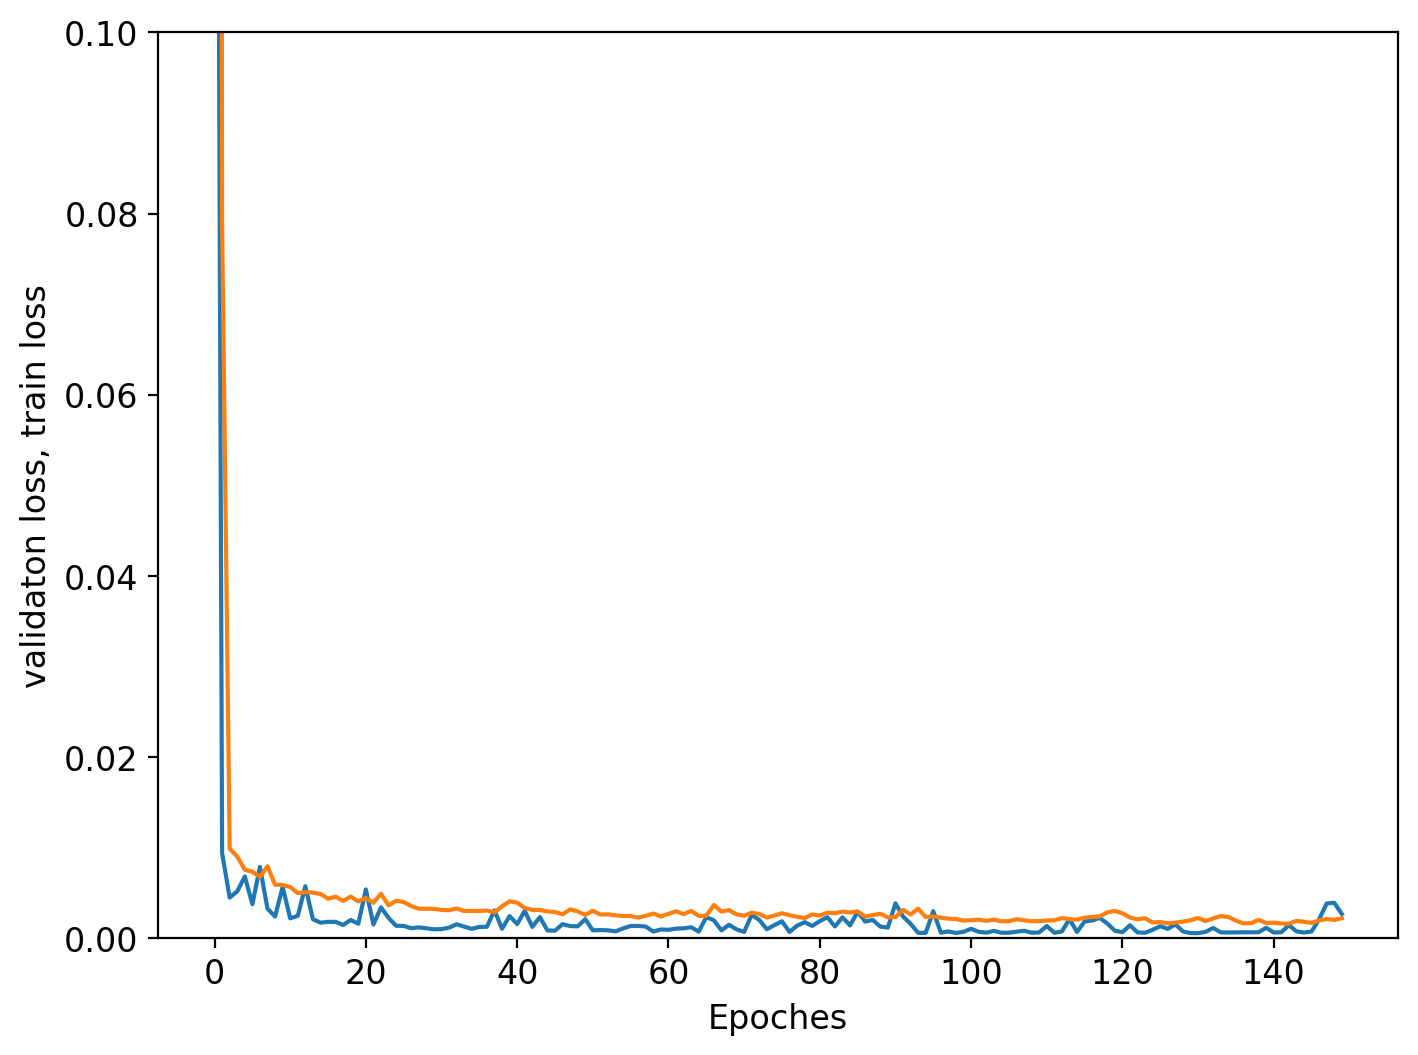

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('Epoches')
plt.ylabel('validaton loss, train loss')
plt.plot(valid_loss)
plt.plot(train_loss)
plt.ylim(0,0.1)
plt.show()

In [25]:
Y_pred = net.predict(X_test)
print(Y_pred)

[[2.8072078]
 [2.8380926]
 [2.886266 ]
 ...
 [2.8771255]
 [2.8042176]
 [2.8550045]]


In [26]:
len(Y_test)

1123

In [27]:
Y_pred

array([[2.8072078],
       [2.8380926],
       [2.886266 ],
       ...,
       [2.8771255],
       [2.8042176],
       [2.8550045]], dtype=float32)

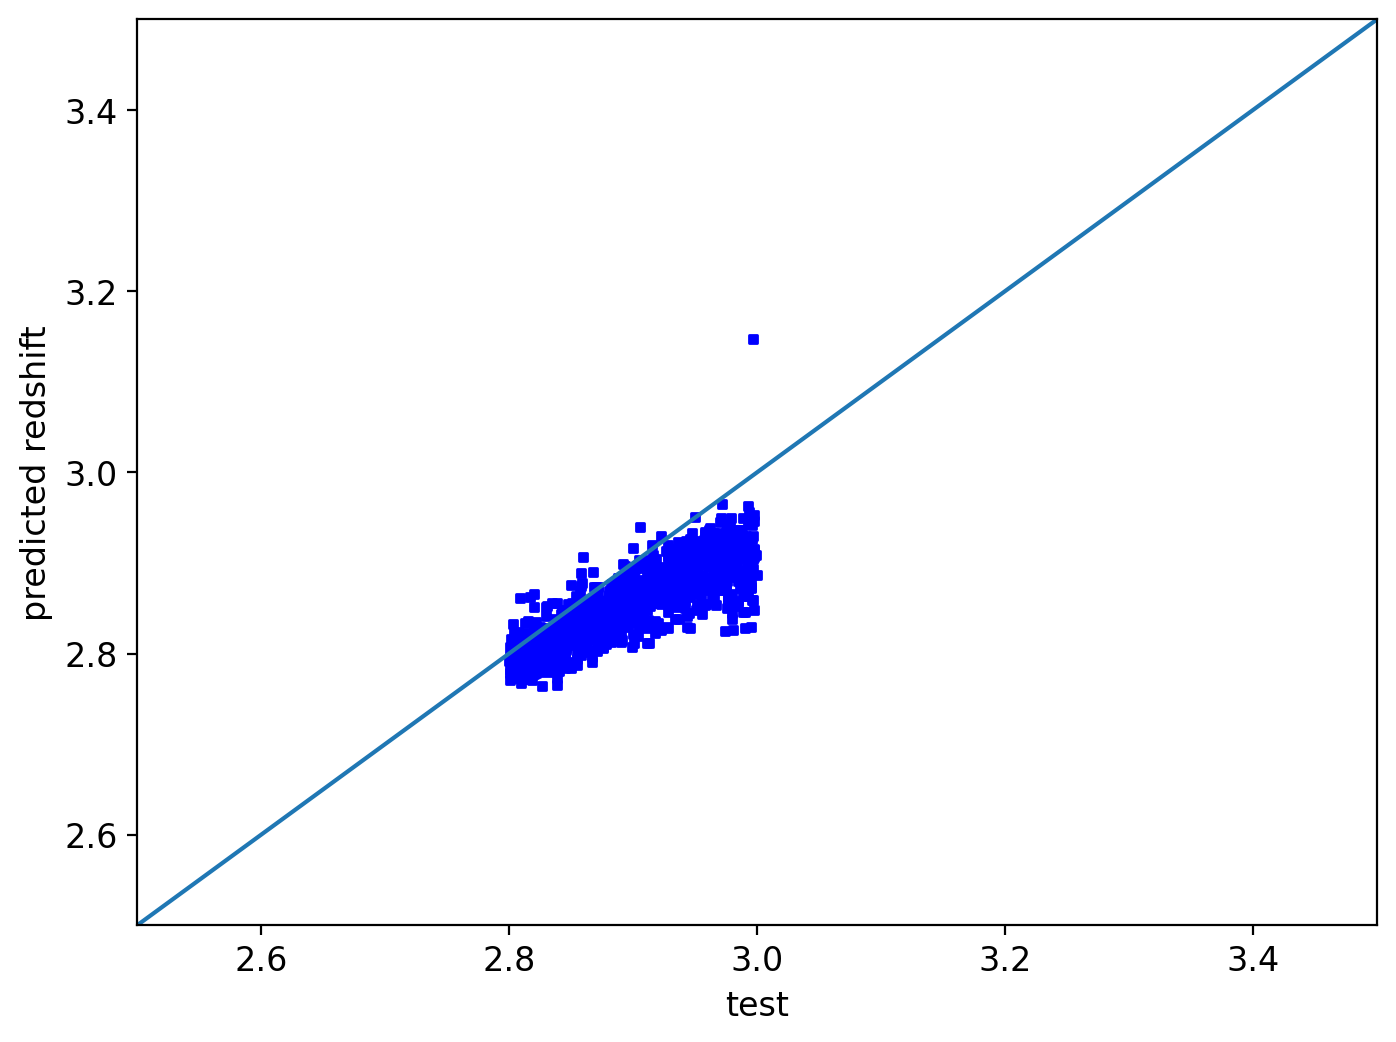

In [28]:
#labels_norm = (Y - label_mean)/label_std

#Z = Y_pred*label_std+label_mean
#y = Y_test*label_std+label_mean

x1=np.linspace(0,7,9)
y1=x1
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(y, Z, s=10, c='b', marker="s")
ax1.scatter(Y_test, Y_pred, s=10, c='b', marker="s")
plt.plot(x1,y1)
plt.xlabel('test')
plt.ylabel('predicted redshift')
plt.xlim(2.5,3.5)
plt.ylim(2.5,3.5)
plt.show()

In [29]:
Y_pred

array([[2.8072078],
       [2.8380926],
       [2.886266 ],
       ...,
       [2.8771255],
       [2.8042176],
       [2.8550045]], dtype=float32)

In [30]:
Y_test.numpy()

array([[2.876],
       [2.934],
       [2.934],
       ...,
       [2.913],
       [2.819],
       [2.888]], dtype=float32)

In [31]:
REL=300000*(Y_pred-Y_test.numpy())/(1+Y_test.numpy())
len(REL)

1123

In [32]:
#REL=300000*(Z-y.numpy())/(1+y.numpy())
#len(REL)

In [33]:
abs(REL).mean()

3373.762344420276

In [34]:
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("F.txt", "a"))

In [35]:
file = open('F.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("F.txt", "a"))
        
with open("F.txt","r") as f:
    print(100*len(f.readlines())/len(REL))

87.71148708815673


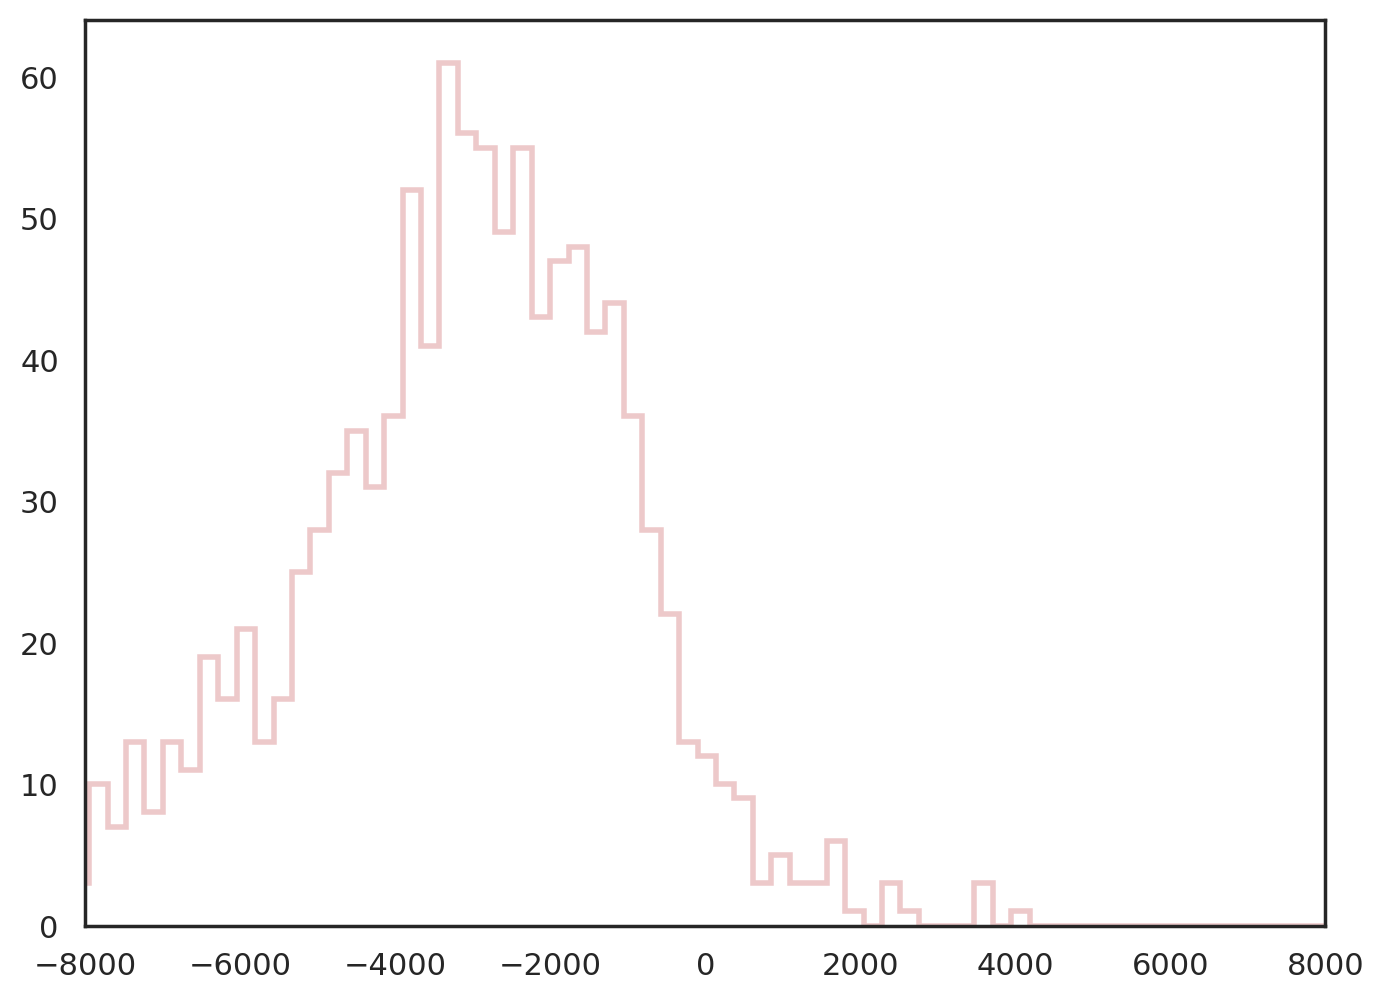

In [36]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL


sns.set_style('white')

plt.hist(data, bins=100,histtype='step',alpha=0.3,edgecolor='r',linewidth=2)
#plt.hist(RE1, bins=1000,histtype='step',alpha=0.3,edgecolor='b',linewidth=2)

plt.xlim(-8000,8000)
#plt.ylim(0,7)
plt.show()